In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
data = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/representative regions/UKESM1-0-LL_2010_2014_representative_regions(ver240113).csv')

#### Calculate dynamic regression 

In [3]:
d_ho2_oh_beta = data.groupby('region').apply(lambda g: sm.OLS(g['ho2_mole'], g[['oh_mole']]).fit().params)
d_ho2_oh_ste = data.groupby('region').apply(lambda g: sm.OLS(g['ho2_mole'], g[['oh_mole']]).fit().HC0_se)

#### Calculate features

In [4]:
a = data['k5'].mean()
#b = data['k8'].mean()
b = 6.34*10**(-15)
c = data['k6'].mean()

data['c'] = data['co_mole']*a/c + data['hcho_mole']
#data['c'] = data['co_mole'] + data['hcho_mole']
#data['c'] = data['co_mole']
data['co_hcho__no'] = data['c']/data['no_mole']
feat = data.groupby('region').mean()[['co_hcho__no']]
feat = pd.DataFrame(feat)
feat_std = data.groupby('region').std()['co_hcho__no']
feat_ct = data.groupby('region').count()['co_hcho__no']
feat_ste = pd.DataFrame(feat_std/np.sqrt(feat_ct/5))

In [5]:
print(a/c)

0.016541058647675896


In [5]:
mod = LinearRegression()
X = feat[['co_hcho__no']]
y = d_ho2_oh_beta['oh_mole']
mod.fit(X,y)
y_pred = mod.predict(X)

In [6]:
d_ho2_oh_beta['beta_adj'] = d_ho2_oh_beta['oh_mole']*0.5 + y_pred*0.5
d_ho2_oh_beta['co_hcho__no'] = feat['co_hcho__no']
d_ho2_oh_beta['beta_adj_ste'] = d_ho2_oh_ste
d_ho2_oh_beta['co_hcho__no_ste'] = feat_ste

([<matplotlib.axis.XTick at 0x7fe53ec78160>,
 [Text(0, 0, '0'), Text(2, 0, '2'), Text(4, 0, '4'), Text(6, 0, '6')])

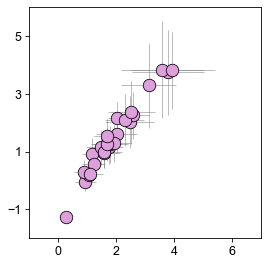

In [13]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=75)
x_values = np.log(d_ho2_oh_beta['beta_adj'])
y_values = np.log(d_ho2_oh_beta['co_hcho__no'])
x_errors = (d_ho2_oh_beta['beta_adj_ste'])**0.5
y_errors = (d_ho2_oh_beta['co_hcho__no_ste'])**0.5

plt.errorbar(x_values, y_values, xerr=x_errors, yerr=y_errors, 
             fmt="o", ecolor="grey", elinewidth=0.5, capsize=None, mfc='plum', mec='black', ms=12, alpha=1, mew=0.75)

plt.xlim([-1,7])
plt.ylim([-2,6])
plt.yticks([-1,1,3,5], fontsize=12)
plt.xticks([0,2,4,6], fontsize=12)

In [8]:
d_ho2_oh_beta = d_ho2_oh_beta[['beta_adj', 'beta_adj_ste', 'co_hcho__no', 'co_hcho__no_ste']]
d_ho2_oh_beta['ln_beta_adj'] = np.log(d_ho2_oh_beta['beta_adj'])
d_ho2_oh_beta['ln_co_hcho__no'] = np.log(d_ho2_oh_beta['co_hcho__no'])
d_ho2_oh_beta['ln_beta_adj_ste'] = np.log(d_ho2_oh_beta['beta_adj_ste'])
d_ho2_oh_beta['ln_co_hcho__no_ste'] = np.log(d_ho2_oh_beta['co_hcho__no_ste'])

d_ho2_oh_beta.to_csv('I7 HO2_OH.csv')